# Process of Benchmarking data

In [5]:
from IPython.display import clear_output
!pip install forest-benchmarking
clear_output()

In [6]:
from functions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

In [7]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [8]:
# target_qubits = [41,42]
target_qubits = [0]
n_qubits = len(target_qubits)

k_m = 200 #number of sequences
n_m = 500 #number of shots

# epsilon = 0.01
# machine_title = '2q-qvm'
machine_title = 'Aspen-M-3'
# noise_model = 'depolarising_noise'
noisy_machine = machine_title

# noisy_machine = 'depolarising_noise' + '_epsilon{}'.format(epsilon)
# noise_model = 'z_noise'
path = os.path.join( os.getcwd(), 'output_storage', noisy_machine)

In [9]:
path

'C:\\Users\\mohsen\\Documents\\Python_pros\\git_controlled\\Randomized_Benchmarking_protocol\\output_storage\\Aspen-M-3'

In [10]:
avg_fdlty_dict = {}
err_fdlty_dict = {}
ordered_layers_dict = {}

In [11]:
def capture_bench_dataframe(path):
    dataframe = pd.read_csv(os.path.join(path, '{}.csv'.format(machine_title) ) )
    dataframe = dataframe[dataframe['target qubits'] == str(target_qubits)]
    return dataframe

def filter_large_errors(dataframe):
    return dataframe[dataframe['error of fidelity'] <= 0.05]

def filter_seqs_shots_num(dataframe, sequences_num, shots_num):
    df = dataframe[dataframe['number of shots'] == shots_num]
    df = dataframe[dataframe['number of sequences'] == sequences_num]
    return df

def capture_bench_arrays(dataframe, version_name):
    dataframe = dataframe[ dataframe['protocol name'] == version_name ]
    ordered_layers = dataframe['circuit depth']
    avg_fdlty_arr = dataframe['average of fidelity']
    err_fdlty_arr = dataframe['error of fidelity']
    return ordered_layers, avg_fdlty_arr, err_fdlty_arr

In [12]:
df = capture_bench_dataframe(path)

In [13]:
df = filter_large_errors(df)
df = filter_seqs_shots_num(df, sequences_num=k_m, shots_num=n_m)

In [14]:
bench_versions = df['protocol name'].unique()
for version in bench_versions:
    avg_fdlty_dict[version] = []
    err_fdlty_dict[version] = []
    ordered_layers_dict[version] = []

    try:
        ordered_layers, avg_fdlty_arr, err_fdlty_arr = capture_bench_arrays(df, version)
        avg_fdlty_dict[version] = avg_fdlty_arr
        err_fdlty_dict[version] = err_fdlty_arr
        ordered_layers_dict[version] = ordered_layers
    except:
        pass

In [15]:
df

,date,target qubits,number of sequences,number of shots,protocol name,circuit depth,average of fidelity,error of fidelity
14,2023-02-09,[0],200,200,native_conditional_single_qubit,1,0.96935,0.014224
15,2023-02-09,[0],200,200,native_conditional_single_qubit,3,0.92535,0.018224
16,2023-02-09,[0],200,200,native_conditional_single_qubit,5,0.91630,0.022137
17,2023-02-09,[0],200,200,native_conditional_single_qubit,7,0.90900,0.024648
18,2023-02-09,[0],200,200,native_conditional_single_qubit,9,0.88875,0.027883
22,2023-03-02,[0],200,500,native_conditional_single_qubit,5,0.92237,0.016243
23,2023-03-02,[0],200,500,native_conditional_single_qubit,10,0.89606,0.021653
24,2023-03-02,[0],200,500,native_conditional_single_qubit,15,0.87739,0.029079
25,2023-03-12,[0],200,500,native_conditional_single_qubit,15,0.87078,0.028918
26,2023-03-12,[0],200,500,native_conditional_single_qubit,20,0.85258,0.031492


In [16]:
err_fdlty_dict

{'native_conditional_single_qubit': 14    0.014224
 15    0.018224
 16    0.022137
 17    0.024648
 18    0.027883
 22    0.016243
 23    0.021653
 24    0.029079
 25    0.028918
 26    0.031492
 27    0.034818
 28    0.038216
 29    0.039526
 30    0.043318
 31    0.040949
 32    0.049852
 Name: error of fidelity, dtype: float64,
 'standard_rb_single_qubit': 33    0.013499
 34    0.017727
 35    0.021771
 36    0.025131
 37    0.028842
 38    0.033254
 39    0.032252
 40    0.037463
 Name: error of fidelity, dtype: float64}

In [17]:
bench_versions

array(['native_conditional_single_qubit', 'standard_rb_single_qubit'],
      dtype=object)

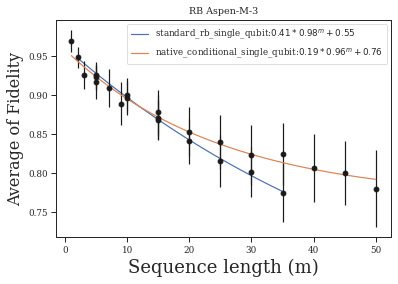

In [19]:
fig = plt.figure()
ax = fig.add_subplot()


for version in ['standard_rb_single_qubit', 'native_conditional_single_qubit']:
# for version in ['native_conditional_conditional_two_qubits']:
# for version in ['native_conditional_single_qubit']:
#     plot_bench_arrays(ax, version, epsilon)
    plot_decay(ordered_layers_dict[version][:], avg_fdlty_dict[version][:],
               err_fdlty_dict[version][:], label = version, axes = ax)

# plt.loglog()
ax.set_xlabel('Sequence length (m)', fontsize=18)
ax.set_ylabel('Average of Fidelity', fontsize=16)
ax.set_title(r'RB {}'.format(noisy_machine))

plt.legend()

fig.savefig(os.path.join(path, 'RB_{}.png'.format(target_qubits)))
